# Final layer activations visualisation

This notebook calculates the final layer activitations for Georgian properties compared to random streetviews.
It then visualises this by projecting these layers down to 2D with PCA and plotting it

# Functions that read in graph, images and calculate final layer activations

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys

import numpy as np
import tensorflow as tf


#This function loads the graph
def load_graph(model_file):
  graph = tf.Graph()
  graph_def = tf.GraphDef()

  with open(model_file, "rb") as f:
    graph_def.ParseFromString(f.read())
  with graph.as_default():
    tf.import_graph_def(graph_def)

  return graph

# This function converts the photo data into a tensor

def read_tensor_from_image_file(file_name,
                                input_height=299,
                                input_width=299,
                                input_mean=0,
                                input_std=255):
  input_name = "file_reader"
  output_name = "normalized"
  file_reader = tf.read_file(file_name, input_name)
  #Handles different image file formats
  if file_name.endswith(".png"):
    image_reader = tf.image.decode_png(
        file_reader, channels=3, name="png_reader")
  elif file_name.endswith(".gif"):
    image_reader = tf.squeeze(
        tf.image.decode_gif(file_reader, name="gif_reader"))
  elif file_name.endswith(".bmp"):
    image_reader = tf.image.decode_bmp(file_reader, name="bmp_reader")
  else:
    image_reader = tf.image.decode_jpeg(
        file_reader, channels=3, name="jpeg_reader")
  float_caster = tf.cast(image_reader, tf.float32)
  dims_expander = tf.expand_dims(float_caster, 0)
  resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
  normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
  sess = tf.Session()
  result = sess.run(normalized)

  return result






In [6]:
#The function that when fed an image returns the network activtations of the final layer

def stylelayeroutput(x):
    file_name=x
    input_mean=128 
    input_std=128 
    input_height=299
    input_width=299  
    input_layer='Mul'
    output_layer='pool_3' #The name of the layer that has been retrained
    input_name = "import/" + input_layer
    output_name = "import/" + output_layer
    input_operation = graph.get_operation_by_name(input_name)
    output_operation = graph.get_operation_by_name(output_name)
    t = read_tensor_from_image_file(file_name, input_height=input_height,input_width=input_width, input_mean=input_mean, input_std=input_std)
    #Runs the session to get the output sets the input data to t the image just read in from file
    results = sess.run(output_operation.outputs[0], {input_operation.outputs[0]: t })#Calculates the activations
    results = np.squeeze(results) #Removes 1 dimensional elements of tensor 
    return results


# Calculates final layer activations

In [11]:
#Reads in the georgian buildings
import os
import pandas as pd
import random


#Reads in the trained network
model_file="filepath to model .pb"

graph=load_graph(model_file)




a="filepath to random street views"

#Reads in the random buildings

b="filepath to Georgian buildings sample"


#Returns a lost of the jpeg files in a folder 
def getim_list(path):
    return[os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg')]



################################################################
# Creates a dataframe of the activiations of 200 Georgian buildings
piclistgeorg=getim_list(b)

list_of_lists = []


with tf.Session(graph=graph) as sess:
 for i in range(200):
  k=piclistgeorg[i]
  list_of_lists.append(stylelayeroutput(k))
    
dfgeorg= pd.DataFrame(list_of_lists) #Converts the lists of lists into a dataframe
    
dfgeorg['Name']='georgian' #Adds a cloumn that labels the data

#################################################################
piclistrand=getim_list(a)

# Creates a dataframe of the activiations of 1000 random streetviews

list_of_lists=[]


#selects 1000 random elements of piclistrand
piclistrand = random.sample(piclistrand, 1000)

with tf.Session(graph=graph) as sess:
 for i in range(1000):
  k=piclistrand[i]
  list_of_lists.append(stylelayeroutput(k))
    
dfrand=pd.DataFrame(list_of_lists) #Converts the lists of lists into a dataframe

dfrand['Name']='random'  #Adds a cloumn that labels the data


################################################################
#Merge the two dataframes by stacking them on top of each other

store= pd.concat([dfgeorg, dfrand], axis=0)

    



# Projects the activations down to 2D and plots them

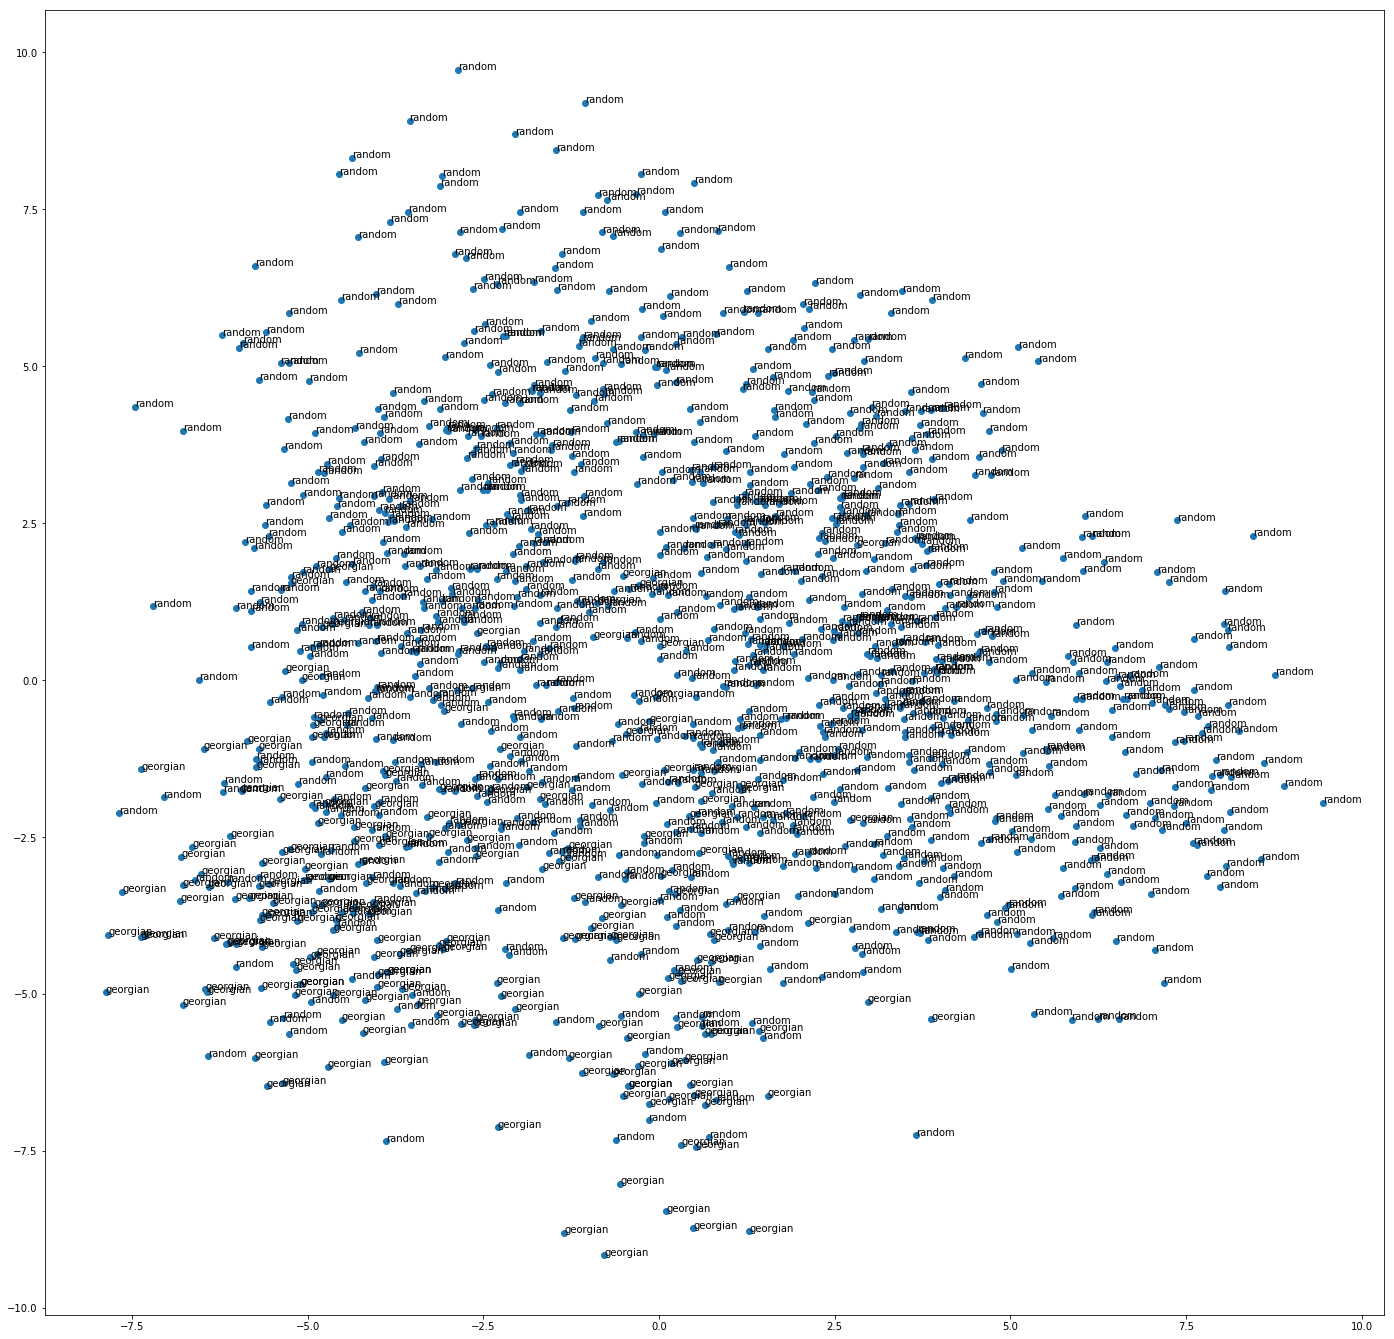

In [14]:
from sklearn.decomposition import PCA
from matplotlib import pyplot


#Projects the final layer activtations down to 2 dimensions and plots them with matplotlib

pca = PCA(n_components=2)
#PCA to reduce dimensions down to 2 dimensions drop the column names
result = pca.fit_transform(store.drop('Name', axis=1))

# create a scatter plot of the projection
pyplot.figure(figsize=(24,24))
pyplot.scatter(result[:, 0], result[:, 1])
words =store['Name']
for i, word in enumerate(words): 
 #Annotate the points with the names
 pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()


In [ ]:
import pandas as pd
import numpy as np
from ggplot import *

#Plots the same data with ggplot

df = pd.DataFrame()

df["cluster"]=store['Name']
df["xcoord"]=result[:,0]
df["ycoord"]=result[:,1]

chart = ggplot( df, aes(x='xcoord', y='ycoord', color='cluster') ) \
        + geom_point(size=40,alpha=1) \


chart